### 데이터 확인
* rating: 제품에 대한 평점
* date: 리뷰 작성 날짜
* variation: 제품의 색상 및 기타 변형 정보
* verified_reviews: 실제 리뷰 텍스트
* feedback: 긍정적인 피드백 여부 (1: 긍정적, 0: 부정적)

# 데이터 로드 및 확인

In [1]:
import pandas as pd

# 데이터 파일 경로
file_path = 'data/amazon_alexa.tsv'
# 데이터 로드
alexa_data = pd.read_csv(file_path, sep='\t')
# 데이터 상위 5개 행 확인
alexa_data.head()


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


# 텍스트 전처리

### null, 공백 리뷰 제거, 불용어 제거, 표제어 처리, 소문자 변환

In [2]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# NLTK 불용어 리스트 다운로드
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# null 및 공백 리뷰 제거
empty_review = alexa_data['verified_reviews'].replace(' ', '') == ''
null_review = alexa_data['verified_reviews'].isnull()

# null 및 공백 제거된 데이터프레임 생성
cleaned_df = alexa_data.drop(alexa_data[empty_review | null_review].index)


# 불용어, 표제어 리스트 가져오기
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def transform_text(text):
    # 소문자 변환
    text = text.lower()
    
    # 특수 문자 및 숫자 제거
    text = re.sub("[^a-zA-Z\s]", "", re.sub('\n', '', text))

    # 불용어
    tokens = word_tokenize(text)
    new_string = []
    for w in tokens:
        if w not in stop_words:
            new_string.append(w)

    s = ' '.join(new_string)
    s = s.strip()

    # 표제어
    tokens = word_tokenize(s)
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos='v')
        new_string.append(lem)

    s = ' '.join(new_string)
    return s.strip()

# 전처리 적용
cleaned_df['cleaned_reviews'] = cleaned_df['verified_reviews'].apply(transform_text)

# 전처리 후 데이터 확인
cleaned_df[['verified_reviews', 'cleaned_reviews']].head()


<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dm/pxz8m2xd2nq59tdmlk4nlyr80000gn/T/ipykernel_1901/1682623058.py:30: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("[^a-zA-Z\s]", "", re.sub('\n', '', text))
[nltk_data] Downloading package punkt_tab to /Users/jhjoo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jhjoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jhjoo/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/jhjoo/nltk_data...


,verified_reviews,cleaned_reviews
0,Love my Echo!,love echo
1,Loved it!,love
2,"Sometimes while playing a game, you can answer...",sometimes play game answer question correctly ...
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learn dinosaurs control l...
4,Music,music


# 감성 레이블 설정(긍정/부정 분류)

In [3]:
# 감성 레이블 설정 (평점이 3점 이상이면 긍정적, 그 이하는 부정적)
cleaned_df['sentiment'] = alexa_data['rating'].apply(lambda x: 1 if x >= 3 else 0)

# 간단한 리뷰 텍스트와 감성 레이블 확인
cleaned_df[['cleaned_reviews', 'sentiment']].head()


,cleaned_reviews,sentiment
0,love echo,1
1,love,1
2,sometimes play game answer question correctly ...,1
3,lot fun thing yr old learn dinosaurs control l...,1
4,music,1


# 텍스트 백터화 및 모델 학습 준비

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 텍스트 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 감성 레이블
y = cleaned_df['sentiment']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"모델 정확도: {accuracy:.4f}")


모델 정확도: 0.9365


# 토픽 모델링(LDA 사용)
> 토픽 모델링은 리뷰 데이터에서 주요 주제를 도출하는 데 유용합니다. 이를 위해 *Latent Dirichlet Allocation (LDA)* 를 사용합니다. 이 방법은 각 리뷰에 여러 주제가 혼합되어 있을 수 있음을 가정하고, 각 리뷰가 어떤 주제에 얼마나 관련 있는지를 계산합니다.

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 사용해 텍스트를 토큰화 및 벡터화 (단어 빈도 기반)
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# LDA 모델 설정
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5개의 토픽을 추출
lda.fit(X)

# 각 토픽에 대해 주요 단어들을 출력하는 함수
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

# 주요 단어 출력
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words)


Topic #0:
echo dot sound great music alexa work quality love speaker

Topic #1:
love alexa smart use play ask music echo connect easy

Topic #2:
great work use product good sound easy time set buy

Topic #3:
like work use easy set echo alexa new learn buy

Topic #4:
love echo music play use alexa great light like alarm



# 긍정/부정 예측 모델
> 이제 머신러닝 모델을 적용해 리뷰 텍스트 기반으로 제품 만족도를 예측하는 모델을 구축할 수 있습니다. 앞서 사용한 로지스틱 회귀 모델 외에도 여러 모델을 적용할 수 있습니다. 예를 들어, 랜덤 포레스트(Random Forest)나 서포트 벡터 머신(SVM)을 사용할 수 있습니다. 여기서는 간단히 랜덤 포레스트를 예시로 설명드리겠습니다.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 텍스트 데이터를 벡터화 (TF-IDF 사용)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 감성 레이블
y = cleaned_df['sentiment']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"랜덤 포레스트 모델 정확도: {accuracy:.4f}")


랜덤 포레스트 모델 정확도: 0.9528


# 평점 예측 모델링

## 데이터 준비 및 벡터화

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 텍스트 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 평점(rating) 데이터 준비
y = cleaned_df['rating']  # 1~5 사이의 평점

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 모델 학습(RF)

In [8]:
# 랜덤 포레스트 모델 학습 (다중 클래스 분류)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"평점 예측 모델 정확도: {accuracy:.4f}")


평점 예측 모델 정확도: 0.8306


## 모델 성능 평가 (혼동 행렬 및 분류 보고서)

In [9]:
# 혼동 행렬 및 분류 보고서 출력
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("혼동 행렬:")
print(conf_matrix)
print("\n분류 보고서:")
print(class_report)


혼동 행렬:
[[  7   0   0   0  18]
 [  0   4   0   0   9]
 [  0   0  14   2  12]
 [  0   0   0  30  58]
 [  1   0   0   4 455]]

분류 보고서:
              precision    recall  f1-score   support

           1       0.88      0.28      0.42        25
           2       1.00      0.31      0.47        13
           3       1.00      0.50      0.67        28
           4       0.83      0.34      0.48        88
           5       0.82      0.99      0.90       460

    accuracy                           0.83       614
   macro avg       0.91      0.48      0.59       614
weighted avg       0.84      0.83      0.80       614



# 시각화

## 감성 분석 시각화

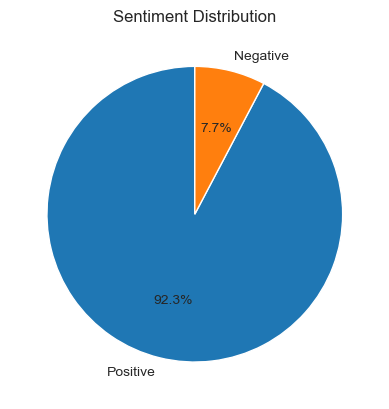

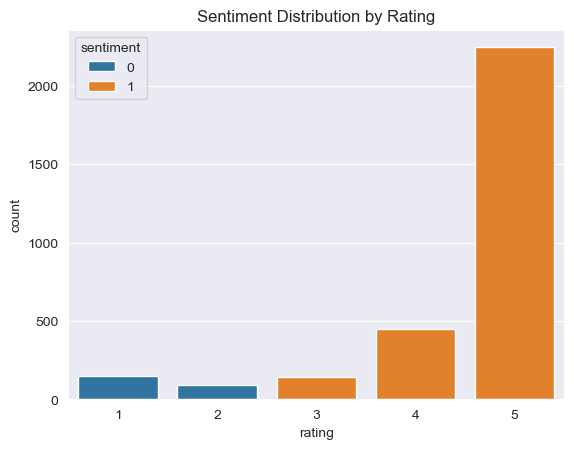

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 감성 비율 시각화 (파이 차트)
sentiment_counts = cleaned_df['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()

# 평점에 따른 감성 분포 (막대 그래프)
sns.countplot(x='rating', hue='sentiment', data=cleaned_df)
plt.title('Sentiment Distribution by Rating')
plt.show()


## 토픽 모델링 결과 시각화 (워드 클라우드)

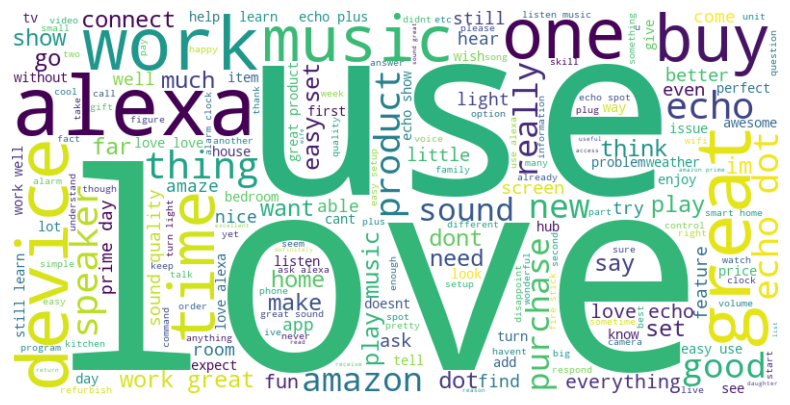

In [11]:
from wordcloud import WordCloud

# 특정 토픽의 주요 단어를 워드 클라우드로 시각화
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_df['cleaned_reviews']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 분류 모델 시각화

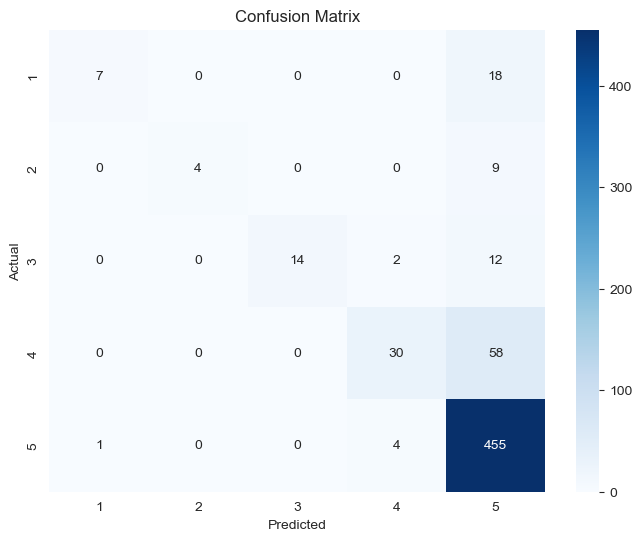

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 오분류 된 리뷰 확인
* 기존 점수와 예측된 점수가 2점이상 차이가 나는 리뷰를 오분류됨으로 정의

In [20]:
# 예측 결과 저장 (y_pred는 이미 예측된 결과)
cleaned_df['predicted_rating'] = rf_model.predict(X)
# 실제 값과 예측 값 비교
mismatched_reviews = cleaned_df[cleaned_df['rating'] != cleaned_df['predicted_rating']]
# 잘못 예측된 리뷰들 확인
misclassification_df = mismatched_reviews[['verified_reviews', 'cleaned_reviews', 'rating', 'predicted_rating']][abs(mismatched_reviews['rating'] - mismatched_reviews['predicted_rating']) >= 2]

misclassification_df.to_csv('out/misclassification_df.csv', index=False)
